In [ ]:
# NOTE: Execute this cell in the beginning
# Do not edit this cell

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from scipy import ndimage
import torch.backends.cudnn as cudnn
import os
import argparse

def set_seed(seed):
    """Sets the global seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed) 

#setting the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# loading MNIST dataset
print('==> Preparing data..')

# We first download the train and test datasets
mnist_train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
mnist_test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

# a dictionary to contain train and test sets
mnist_dataset_sizes = {'train' : mnist_train_dataset.__len__(), 'test' : mnist_test_dataset.__len__()} 

#defining the train and test loader
mnist_train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_train_dataset,
                 batch_size=256,
                 shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(
                dataset=mnist_test_dataset,
                batch_size=1,
                shuffle=True)

# a dictionary to contain train and test loaders
mnist_dataloaders = {'train' : mnist_train_loader ,'test' : mnist_test_loader} 

==> Preparing data..


In [ ]:
#Defining LeNet Model
#we can use this as MNIST not a very complex dataset to learn on
# LeNet Model definition

""""
You should implement LeNet model with the below configuration. Consider that input images are having a single channel:

1.   Conv layer with 10 output channels and filter size 5
2.   Conv layer with 20 output channels and filter size 5
3.   Dropout layer
4.   Fully connected layer with output size 50
5.   Takes input from step 4 and output 10 dimensions (main class labels) through a fully connected layer
"""

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        """YOUR CODE STARTS HERE"""
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc2_ssl = nn.Linear(50, 10)
        """YOUR CODE ENDS HERE"""

    # network architecture for classification head: 
    # conv1 -> maxpool2D-> Relu->conv2->conv2_drop->maxpool2D->Relu->Reshape->fc1->Relu->dropout->fc2,log-sofmax
    def forward(self, x):
        """YOUR CODE STARTS HERE"""
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        # classification head
        out_cls = self.fc2(x)
        #apply log_softmax on the output
        return F.log_softmax(x, dim=1)
        """YOUR CODE ENDS HERE"""

In [ ]:
#building model
print('==> Building the LeNet model')
mnist_model = LeNet().to(device)
#defining the loss function
mnist_criterion = nn.CrossEntropyLoss()
#setting the optimizer and number of training epochs
mnist_optimizer = optim.Adam(mnist_model.parameters(), lr=0.001)
mnist_num_epochs= 20

==> Building the LeNet model


In [ ]:
#Training LeNet model
def train_mnist_model(model, data_loaders, dataset_sizes, criterion, optimizer, num_epochs, device):
    
    model = model.to(device)
    # set train mode
    model.train()
    
    # for each epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        
        running_loss, running_corrects = 0.0, 0
        
        # for each batch
        for inputs, labels in data_loaders['train']:
            inputs = inputs.to(device)
            labels =labels.to(device)  

            """YOUR CODE STARTS HERE"""

            # set optimizer gradient as 0
            optimizer.zero_grad() 
            
            # get the model output
            outputs = model(inputs)
            
            # get the prediction of model by using argmax or max
            _, preds = torch.max(outputs, 1)
            
            # calculate loss of the output
            loss = criterion(outputs, labels)
            
            # backpropagate the loss
            loss.backward()
            
            # update model parameters using optimzier
            optimizer.step()

            """YOUR CODE ENDS HERE"""
            
            # calculate total loss of the batch
            batch_loss_total = loss.item() * inputs.size(0)

            # cumluative sum of loss
            running_loss += batch_loss_total 

            # cumulative sum of correct count
            running_corrects += torch.sum(preds == labels.data) 

        
        #calculating the loss and accuracy for the epoch   
        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        print('-' * 10)
        
    
    # model evaluation
    else:
        model.eval() 
        running_loss, running_corrects = 0.0, 0
        
        # for each batch
        for inputs, labels in data_loaders['test']:
            inputs = inputs.to(device)
            labels =labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
                    
            
            running_loss += loss.item() * inputs.size(0) 
            running_corrects += torch.sum(preds == labels.data) 
         
        #calculating the loss and accuracy
        test_loss = running_loss / dataset_sizes['test']
        test_acc = (running_corrects.double() / dataset_sizes['test']).item()
        print('<Test Loss: {:.4f} Acc: {:.4f}>'.format(test_loss, test_acc))

#training LeNet on the MNIST dataset
train_mnist_model(mnist_model, mnist_dataloaders, mnist_dataset_sizes, mnist_criterion, mnist_optimizer, mnist_num_epochs, device)

Epoch 1/20
Train Loss: 2.5899 Acc: 0.4215
----------
Epoch 2/20
Train Loss: 2.2041 Acc: 0.5080
----------
Epoch 3/20
Train Loss: 2.1450 Acc: 0.5182
----------
Epoch 4/20
Train Loss: 2.1022 Acc: 0.5263
----------
Epoch 5/20
Train Loss: 2.1004 Acc: 0.5260
----------
Epoch 6/20
Train Loss: 2.0795 Acc: 0.5298
----------
Epoch 7/20
Train Loss: 2.0682 Acc: 0.5312
----------
Epoch 8/20
Train Loss: 2.0683 Acc: 0.5310
----------
Epoch 9/20
Train Loss: 2.0747 Acc: 0.5287
----------
Epoch 10/20
Train Loss: 2.0658 Acc: 0.5308
----------
Epoch 11/20
Train Loss: 2.0474 Acc: 0.5334
----------
Epoch 12/20
Train Loss: 2.0524 Acc: 0.5305
----------
Epoch 13/20
Train Loss: 2.0474 Acc: 0.5317
----------
Epoch 14/20
Train Loss: 2.0608 Acc: 0.5295
----------
Epoch 15/20
Train Loss: 2.0408 Acc: 0.5338
----------
Epoch 16/20
Train Loss: 2.0435 Acc: 0.5327
----------
Epoch 17/20
Train Loss: 2.0402 Acc: 0.5341
----------
Epoch 18/20
Train Loss: 2.0301 Acc: 0.5363
----------
Epoch 19/20
Train Loss: 2.0139 Acc: 0

In [ ]:
# Save the trained LeNet Model
print('==> Saving model for MNIST..')
torch.save(mnist_model.state_dict(), 'lenet_mnist_model.pth')

#load your pretrained model
print('==> Loading saved model for MNIST..')
mnist_model = LeNet().to(device)
mnist_model.load_state_dict(torch.load('lenet_mnist_model.pth'))
mnist_model.eval()

==> Saving model for MNIST..
==> Loading saved model for MNIST..


LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (fc2_ssl): Linear(in_features=50, out_features=10, bias=True)
)

# Fast Gradient Singed Method attack (FGSM)
In this part, you will implement the FGSM attack, a white box attack. This concept was covered in the Adversarial Robustness lectures. 

In [ ]:
# Fast Gradient Singed Method attack (FGSM)

#Inputs:
# Model is the trained model for the target dataset
# target is the ground truth label of the image
# epsilon is the hyper parameter which shows the degree of perturbation

def fgsm_attack(model, image, target, epsilon):

    """YOUR CODE STARTS HERE"""

    # Set requires_grad attribute of tensor. 
    # This is necessary for the attack
    image.requires_grad = True

    # Forward pass the data through the model
    output = model(image)

    # get the index of the max log-probability which is basically the prediction of the model
    init_pred = output.max(1, keepdim=True)[1] 
    
    # If the initial prediction is wrong, an attack is not required
    # return the image
    if init_pred[0].item() != target[0].item():
        return image
    
    # Calculate the nll loss
    # Hint: you will find it in the pytorch library
    loss = F.nll_loss(output, target)

    # Zero all existing gradients
    #i.e do model.zero_grad()
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect gradient data
    data_grad = image.grad.data
    
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    #recall the formula for FGSM attack
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    """YOUR CODE ENDS HERE"""

    
    # Return the perturbed image
    return perturbed_image

In [ ]:
## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

q = torch.rand(1, 28, 28).to(device)
## Please DONOT remove these lines. 

### YOUR CODE STARTS HERE ###

#set target=1
target = torch.tensor([1]).to(device)

#call the fgsm_attack function with mnist_model, q, target and epsilon=0.3 as input parameters
perturbed_data = fgsm_attack(mnist_model, q, target, epsilon=0.3)

#print the mean value of the above resultant tensor
torch.mean(perturbed_data)

### YOUR CODE ENDS HERE ###


tensor(0.4986, device='cuda:0', grad_fn=<MeanBackward0>)

### Question 1: FGSM attack - part1

What is the range of the mean value of the perturbed data?


1.   0.05 - 0.1
2.   0.15 - 0.25
3.   0.3 - 0.5
4.   0.7 - 0.9

Answer (3)

In [ ]:
# values for epsilon hyper-parameter for FGSM attack
fgsm_epsilons = [0, .05, .1, .15, .2, .25, .3]

#This is where we test the effect of the attack on the trained model

#Inputs:
# model is the pretrained model
#test_loader contains the test dataset
#other parameters are set based on the type of the attack

def attack_test(model, device, test_loader, epsilon, iters, attack='fgsm', alpha=1 ):

    # Accuracy counter. accumulates the number of correctly predicted exampels
    correct = 0

    # to store adversarial examples for visualisation purpose
    adv_examples = []  

    # to store original examples for visualisation purpose
    orig_examples = []


    # Loop over all examples in test set
    for data, target in test_loader:

        """YOUR CODE STARTS HERE"""

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability (model prediction of the image)
        
        # Call the Attack
        if attack == 'fgsm':
            perturbed_data = fgsm_attack(model, data, target, epsilon=epsilon )
      
        # Re-classify the perturbed image
        output = model(perturbed_data)

        # get the index of the max log-probability (model prediction of the perturbed image)
        final_pred = output.max(1, keepdim=True)[1] 

        """YOUR CODE ENDS HERE"""

        #check if the perturbation hasn't affected the classification
        #if not affected store them as they are 0 epsilon cases which is equivalent to no adversarial attack
        if final_pred[0].item() == target[0].item():  
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                orig_ex = data.squeeze().detach().cpu().numpy()


                adv_examples.append((init_pred[0].item(), final_pred[0].item(), adv_ex))
                orig_examples.append((target[0].item(), init_pred[0].item(), orig_ex))
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                orig_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred[0].item(), final_pred[0].item(), adv_ex))
                orig_examples.append((target[0].item(), init_pred[0].item(), orig_ex))

    # Calculate final accuracy for this epsilon values
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial examples and their corresponding original images
    return final_acc, adv_examples, orig_examples

In [ ]:
#FGSM attack

#list to store the model accuracy after attack for every epsilon value in the list
mnist_fgsm_accuracies = []  

# list to collect adversarial examples returned from the attack_test function for every epsilon value in the list
mnist_fgsm_examples = []  

#list to collect original images corresponding the collected adversarial examples
mnist_fgsm_orig_examples = []  

# Run test for each epsilon
"""YOUR CODE STARTS HERE"""

for eps in fgsm_epsilons:
    acc, ex, orig = attack_test(mnist_model, device, mnist_test_loader, eps, attack='fgsm', alpha=1, iters=0)
    mnist_fgsm_accuracies.append(acc)

    #store attacked examples
    mnist_fgsm_examples.append(ex)

    #store original examples
    mnist_fgsm_orig_examples.append(orig)

"""YOUR CODE ENDS HERE"""


Epsilon: 0	Test Accuracy = 9863 / 10000 = 0.9863
Epsilon: 0.05	Test Accuracy = 9490 / 10000 = 0.949
Epsilon: 0.1	Test Accuracy = 8660 / 10000 = 0.866
Epsilon: 0.15	Test Accuracy = 6887 / 10000 = 0.6887
Epsilon: 0.2	Test Accuracy = 4351 / 10000 = 0.4351
Epsilon: 0.25	Test Accuracy = 2287 / 10000 = 0.2287
Epsilon: 0.3	Test Accuracy = 1180 / 10000 = 0.118


'YOUR CODE ENDS HERE'

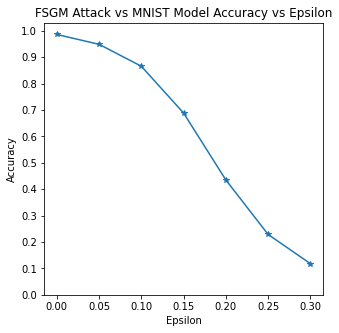

In [ ]:
#Accuracy after attack vs epsilon
#you will see a downwards trend
plt.figure(figsize=(5,5))
plt.plot(fgsm_epsilons, mnist_fgsm_accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("FSGM Attack vs MNIST Model Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

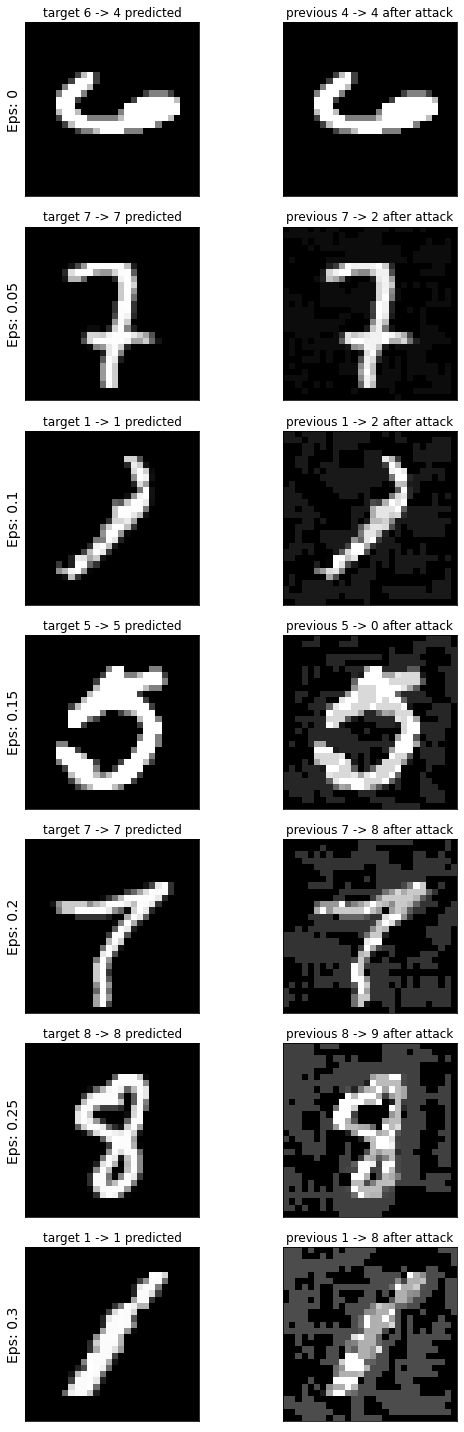

In [ ]:
# Plot several examples vs their adversarial samples at each epsilon for fgms attack
cnt = 0
plt.figure(figsize=(8,20))
for i in range(len(fgsm_epsilons)):
    for j in range(2):
        cnt += 1
        plt.subplot(len(fgsm_epsilons),2,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j==0:
            plt.ylabel("Eps: {}".format(fgsm_epsilons[i]), fontsize=14)
    
            orig,adv,ex = mnist_fgsm_orig_examples[i][0]
            plt.title("target "+"{} -> {}".format(orig, adv)+ " predicted")
            plt.imshow(ex, cmap="gray")
        else:
            orig,adv,ex = mnist_fgsm_examples[i][0]
            plt.title("previous "+"{} -> {}".format(orig, adv)+ " after attack")
            plt.imshow(ex, cmap="gray")
            
plt.tight_layout()
plt.show()

In [ ]:
print(math.floor(np.sum(np.array(mnist_fgsm_accuracies))))

4


### Question 2: FGSM attack - part2

What is the range of the floor value of the sum of elements in the list containing accuracies corresponding to different epsilon values?


1.   1 - 2
2.   3 - 6
3.   7 - 8
4.   0 - 1

Answer (2)

# Self-supervised Learning


In this section, the task is to implement the rotation-based self-supervised task. We will use the previously implemented LeNet model (with slight modification) and the MNIST dataset.

In this specific case, our model has two heads - one head for the main classification (10 classes, in MNIST), and another head for the rotation prediction (4 rotations). The second head performs self-supervised learning here. 

You should implement a model with the below configuration. Consider that input images are having a single channel:

1.   Conv layer with 10 output channels and filter size 5
2.   Conv layer with 20 output channels and filter size 5
3.   Dropout layer
4.   Fully connected layer with output size 50
5.   Branch out 2 heads, one for the main classification head and one for the   rotation classification heads.

  *   Takes input from step 4 and output 10 dimensions (main class labels) through a fully connected layer
  *   Takes input from step 4 and output 4 dimensions(rotation class labels) through a fully connected layer

**Your task is to implement the above model**. In the implementation, you should **define** these layers, and then define the **forward pass** of the model. 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torch.utils.data
import numpy as np


import torchvision
import torchvision.transforms as transforms
torch.manual_seed(1)

# Assumes that tensor is (nchannels, height, width)
def tensor_rot_90(x):

    """YOUR CODE STARTS HERE"""
    return x.flip(2).transpose(1, 2)
    """YOUR CODE ENDS HERE"""


def tensor_rot_180(x):

    """YOUR CODE STARTS HERE"""
    return x.flip(2).flip(1)
    """YOUR CODE ENDS HERE"""


def tensor_rot_270(x):

    """YOUR CODE STARTS HERE"""
    return x.transpose(1, 2).flip(2)
    """YOUR CODE ENDS HERE"""


def rotate_batch_with_labels(batch, labels):
	images = []
	for img, label in zip(batch, labels):
		if label == 1:
			img = tensor_rot_90(img)
		elif label == 2:
			img = tensor_rot_180(img)
		elif label == 3:
			img = tensor_rot_270(img)
		images.append(img.unsqueeze(0))
	return torch.cat(images)
 


def rotate_batch(batch, label):
	if label == 'rand':
		labels = torch.randint(4, (len(batch),), dtype=torch.long)
	elif label == 'expand':
		labels = torch.cat([torch.zeros(len(batch), dtype=torch.long),
					torch.zeros(len(batch), dtype=torch.long) + 1,
					torch.zeros(len(batch), dtype=torch.long) + 2,
					torch.zeros(len(batch), dtype=torch.long) + 3])
		batch = batch.repeat((4,1,1,1))
	else:
		assert isinstance(label, int)
		labels = torch.zeros((len(batch),), dtype=torch.long) + label
	return rotate_batch_with_labels(batch, labels), labels

# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        """YOUR CODE STARTS HERE"""
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc2_ssl = nn.Linear(50, 4)
        """YOUR CODE ENDS HERE"""

    # network architecture for classification head: 
    # conv1 -> maxpool2D-> Relu->conv2->conv2_drop->maxpool2D->Relu->Reshape->fc1->Relu->dropout->fc2,fc2_ssl
    def forward(self, x):
        """YOUR CODE STARTS HERE"""
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        # classification head
        out_cls = self.fc2(x)
        # self supervised head                
        out_ssl = self.fc2_ssl(x)
        """YOUR CODE ENDS HERE"""
        return out_cls, out_ssl

# MNIST Test dataset and dataloader declaration
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

# the datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

# Initialize the network
net = Net().to(device)

parameters = list(net.parameters())
optimizer = optim.SGD(parameters, lr=0.1, momentum=0.9, weight_decay=5e-4)

criterion = nn.CrossEntropyLoss().to(device)
print('Running...')

def train(epoch):
    net.train()    
    
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        
        inputs, labels = inputs.to(device), labels.to(device)        
        labels_full = labels.repeat(4)            
        
        ## Self supervised head
        inputs_ssh, labels_ssh = rotate_batch(inputs, "expand")
        inputs_ssh, labels_ssh = inputs_ssh.to(device), labels_ssh.to(device)
        # outputs_clh , outputs_ssh denotes classification head output and self supervision head output respectively 
        outputs_clh, outputs_ssh = net(inputs_ssh) 
        loss = criterion(outputs_clh, labels_full)
        loss_ssh = criterion(outputs_ssh, labels_ssh)
        loss += loss_ssh

        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
          print(('Epoch: [%d]; Iter: [%d/%d]; Loss: %f' %(epoch,batch_idx, len(trainloader),loss.item())))


## Funtion to compute test accuracy using model already trained with additional self-supervised head..
def test():
        net.eval()
        net.to(device)
        test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs,_ = net(inputs)
                # loss = criterion(outputs, targets)

                # test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        acc = 100.*correct/total
        print('Test Accuracy: %f' %(acc))

CUDA Available:  True
Running...


In [ ]:
# Let us train the network for 1 epoch

set_seed(0)

for epoch in range(0, 1):
  train(epoch)

Epoch: [0]; Iter: [0/469]; Loss: 3.755764
Epoch: [0]; Iter: [50/469]; Loss: 2.273945
Epoch: [0]; Iter: [100/469]; Loss: 1.933250
Epoch: [0]; Iter: [150/469]; Loss: 2.122859
Epoch: [0]; Iter: [200/469]; Loss: 1.643487
Epoch: [0]; Iter: [250/469]; Loss: 1.424067
Epoch: [0]; Iter: [300/469]; Loss: 1.472347
Epoch: [0]; Iter: [350/469]; Loss: 1.481440
Epoch: [0]; Iter: [400/469]; Loss: 1.301159
Epoch: [0]; Iter: [450/469]; Loss: 1.510070


In [ ]:
test()

Test Accuracy: 91.020000


In [ ]:
# The below code will output the logits of the rotation head of the classifier.
# Execute it and answer the question below

net.eval()
net.to(device)
test_loss, correct, total = 0, 0, 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        break

input = inputs[2:3]
target = targets[2:3]

outputs_cl,outputs_ssh = net(input)

print(math.floor(int(torch.mean(torch.sum(outputs_ssh.data) + torch.sum(outputs_cl.data)))))

1


### Question 3: Self-supervised learning

Follow the steps and mark the answer: \\
1) Add the values in the ssl output tensor. \\
2) Add the values in the cl output tensor. \\
3) Add the above two values. \\
4) Report the closest number to the result as your answer. \\

1.   0.15
2.   1.35
3.   3.43
4.   2.34

Answer (2)